In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.signal import butter, filtfilt

# FORELÆSNING 7: Feature engineering, PPG og regression

> Feature-definition, PPG-fysiologi, lineær regression og variationsmål.

### Underviser: Martin Siemienski Andersen mvan@hst.aau.dk

**ST2 - Anvendt Programmering**

# ST2 ANVENDT PROGRAMMERING – Overblik

## Alle forelæsninger

| # | Forelæsning | Mappe | Primære emner |
|---|------------|-------|----------------|
| 1 | Hej C og Python | oop_1 | Programmeringssprog, grundlæggende syntaks, miljøopsætning |
| 2 | Objekter, indkapsling, interaktion | oop_2 | Klasser, metoder, dataindkapsling, objektinteraktion |
| 3 | Filer og dataindlæsning | oop_3 | Fra tekstfil til objekter |
| 4 | OOP-integration workshop | oop_4_workshop | Integration af OOP, fil-I/O, visualisering; overvågningssystemer til enheder |
| 5 | Signalgrundlag | signals_1 | EKG-fysiologi, statistik, peak-detektion |
| 6 | Filtrering og mekaniske signaler | signals_2 | Filtrering, SCG-fysiologi, mekanisk timing, Envelope-udtrækning |
| **7** | **Feature engineering, PPG og regression** | **signals_3** | **Feature-definition, PPG-fysiologi, lineær regression, variationsmål** |
| 8 | Signalintegration og etik | signals_4_workshop | Multimodal integration, refleksion over signal-workflow, etisk analyse |
| 9 | Lineær regression med populationsdata | populations_data_1 | Lineær regression, modelvalidering, residualer |
| 10 | Datavisualisering og unsupervised læring | populations_data_2 | Datavisualisering, fordelinger, scatter plots, k-means clustering (Iris-datasæt) |
| 11 | Supervised learning: klassifikation | populations_data_3 | k-NN-klassifikation, beslutningsgrænser, modelevaluering |
| 12 | Data-integration workshop | populations_data_4_workshop | End-to-end analyse: regression, clustering, klassifikation, reproducerbarhed, formidling |

# Overblik (i dag)

- Vi arbejder med PPG og **Feature**‑udtræk
- Vi går fra rå tidsserie → beats → **Feature**‑tabel
- Vi afslutter med at præsentere og fortolke resultater (variation/usikkerhed)

**Hvorfor skal vi kunne det?**
- Det er ofte **Features** vi rent faktisk vil vide noget om (fx puls, variation, amplitude, rise time)
- Features gør signaler sammenlignelige og klar til statistik/ML/QA
- Gode **Feature**‑mål giver et enkelt, målbart svar på et fysiologisk spørgsmål


# Etik: hvorfor gemme Features istedet for en tidsserie

## Idéen
- Rå biosignaler kan rumme mere information end nødvendigt for formålet (og kan være følsomme).
- **Feature**‑tabeller er ofte tilstrækkelige til statistik/ML/QA og kan reducere risiko ved deling og opbevaring.


## Vigtige nuancer
- **Feature** er ikke automatisk anonymisering: afledte data kan stadig være personoplysninger/helbredsoplysninger.
- Valget handler om *formål* og *nødvendighed* — og om at dokumentere hvad du har gjort.

**Referencer (GDPR, EUR‑Lex)**
- Dataminimering: art. 5(1)(c) https://eur-lex.europa.eu/eli/reg/2016/679/oj
- Formålsbegrænsning: art. 5(1)(b) https://eur-lex.europa.eu/eli/reg/2016/679/oj
- Privacy by design: art. 25 https://eur-lex.europa.eu/eli/reg/2016/679/oj
- Sikkerhed ved behandling: art. 32 https://eur-lex.europa.eu/eli/reg/2016/679/oj
- Særlige kategorier (helbredsoplysninger): art. 9 https://eur-lex.europa.eu/eli/reg/2016/679/oj

# Feature

## Definition
- En **Feature** er en funktion $f(\mathbf{x})$ der kortlægger et signal (eller et segment/beat) til et tal:
  $$f: \mathbb{R}^N \to \mathbb{R}$$
- Målet er at opsummere *relevant* information og ignorere resten (støj/irrelevant variation).

## Kvalitetskriterier (tommelregler)
- **Fortolkbar**: kan forklares fysiologisk/teknisk
- **Robust**: ændrer sig ikke voldsomt ved små artefakter/parameterændringer
- **Reproducerbar**: samme data + samme pipeline ⇒ samme tal
- **Brugbar**: hjælper på et konkret spørgsmål (QA, statistik, ML)

## Eksempler i PPG
- Amplitude (peak − baseline/foot)
- Rise time (foot → peak)
- IBI (inter-beat interval) og BPM

# Forskel på en Feature og et Filter

- Et **filter** ændrer et signal for at fremhæve/fjerne bestemte mønstre.
- En **Feature** udtrækker et *tal* (eller få tal) der opsummerer noget relevant i signalet/et beat

## Sammenligning
- **Output**: filter → signal; **Feature** → tal/vektor (Feature‑tabel)
- **Formål**: filter → støjreduktion/separation; **Feature** → måling/opsummering til statistik/ML/QA
- **Matematik**: filtre er ofte lineære/tidsinvariante (LTI); **Feature** er ofte ikke‑lineær (peak, max, threshold, logik)

## Man kan (næsten) sige: “Feature er et informations‑filter”
- En **Feature** “filtrerer information” ved at beholde det vi vil måle og ignorere resten.

## Eksempel (PPG)
- Low‑pass filter: gør pulskurven glattere → lettere peak detection
- **Feature**: amplitude, rise time, IBI/BPM → tal pr. beat der kan sammenlignes og plottes med fx error bars

# Definer det underliggende information fra en waveform

In [ ]:
# Generate from features: amplitude, frequency, phase
fs = 100  # sampling frequency (Hz)
time_max = 7
t = np.linspace(0, time_max, fs * time_max)  
f0 = 0.5  # frequency (Hz)
A = 2.5  # amplitude
phase = np.pi / 4  # phase offset

# Clean signal
clean_signal = A * np.sin(2 * np.pi * f0 * t + phase)
# Add noise
noise = np.random.normal(0, 0.3, len(t))
noisy_signal = clean_signal + noise
# Apply a low-pass filter (Butterworth)
b, a = butter(2, 5, fs=fs, btype='low',)
filtered_signal = filtfilt(b, a, noisy_signal)
def peak_time(n, f0, phase):
    return (np.pi/2 - phase + n * 2*np.pi) / (2 * np.pi * f0)



# Visualization
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Top plot: Filter example
axes[0].plot(t, noisy_signal, 'blue', alpha=0.5, linewidth=1, label='Noisy signal (raw)')
axes[0].plot(t, filtered_signal, 'black', linewidth=2, label='Filtered signal (low-pass)')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude')
axes[0].set_title('5Hz Lowpass Filter: Signal → Signal < 5Hz (removes noise, preserves shape)', fontsize=12, weight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Bottom plot: Feature extraction (improved)
axes[1].plot(t, clean_signal, 'black', linewidth=2, label='Real signal')
axes[1].plot(t, filtered_signal, 'red', linewidth=2,linestyle="--", label='Filtered signal')
axes[1].arrow(peak_time(1, f0, phase), 0, 0, A,
               head_width=0.05, head_length=0.2, fc='red', ec='red', length_includes_head=True, label='Amplitude')
axes[1].arrow(peak_time(2, f0, phase), A+0.3, (peak_time(2, f0, phase)-peak_time(1, f0, phase)), 0,
               head_width=0.2, head_length=0.05, fc='green', ec='green', length_includes_head=True, label='Period', )
axes[1].arrow(0, 0, peak_time(0, f0, phase), 0,
               head_width=0.2, head_length=0.05, fc='blue', ec='blue', length_includes_head=True, label='Phase')

axes[1].set_xlabel('Time (s)', fontsize=11)
axes[1].set_ylabel('Amplitude', fontsize=11)
axes[1].set_title(r'Features: Amplitude, Period, Phase (Signal is 100% defined with 3 features)', fontsize=12, weight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()


# Fra signal til Features

## Struktur
- Én række pr. beat (eller pr. tidsvindue)
- Kolonner = **Feature**‑mål + evt. kvalitet/flag

## Eksempel på Features (beat‑niveau)
*Fra sinus eksemplet:*
- `phase`
- `perioden`
- `amplituden`

*Fra SCG og EKG:*
- `RR`
- `RtoS1` (tidspunkt)
- `RtoS2` (inter-beat interval)
- `S1toS2`

![s1s2_classification](files/s1s2_classification.png)

# Variation og “error bars” (hvordan og hvordan man læser dem)

In [ ]:

# Load the data
R, S1, S2 = np.genfromtxt('files/peaks_ECGPCG2.csv', delimiter=',', skip_header=1, unpack=True)
# Calculate timing intervals (in samples, convert to time if needed)
R_to_S2 = S2 - R
S1_to_S2 = S2 - S1

df = pd.DataFrame({'R_to_S2': R_to_S2,'S1_to_S2': S1_to_S2})
# Calculate statistics for each interval

# Den lette måde, brug pandas describe
df_desc = df.describe().T # .T betyder transpose
df_desc["sem"] = df_desc["std"] / np.sqrt(df_desc["count"])

features = df_desc.index.to_list()
means = df_desc['mean'].to_list()
stds = df_desc['std'].to_list()
sems = df_desc['sem'].to_list()
counts = df_desc['count'].to_list()


In [ ]:
# Bar plot with error bars
fig, ax = plt.subplots(figsize=(10, 6))
x_pos = np.arange(len(df_desc))
ax.bar(x_pos, means, yerr=stds, capsize=10, alpha=0.7, color='lightgreen', edgecolor='black',
       error_kw={'linewidth': 2, 'ecolor': 'darkgreen'})
ax.set_xticks(x_pos)
ax.set_xticklabels(features)
ax.set_ylabel('Interval (samples)', fontsize=12)
ax.set_title('Timing Intervals: Mean ± Standard Deviation', fontsize=12, weight='bold')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()



## Hvad viser error bars?
- Error bars viser *variation* eller *usikkerhed* omkring et tal (typisk et gennemsnit).
- Vigtigt: man skal altid sige hvad de betyder (ellers kan de misforstås).


In [ ]:
# Print statistics
print("="*70)
print("TIMING INTERVALS STATISTICS")
print("="*70)
print(f"{'Interval':<15} {'Mean':<12} {'Std Dev':<12} {'SEM':<12} {'n':<5}")
print("-"*70)
for i, interval in enumerate(features):
    print(f"{interval:<15} {means[i]:<12.4f} {stds[i]:<12.4f} {sems[i]:<12.4f} {counts[i]:<5}")
print("="*70)
print("\nInterpretation:")
print("  Std Dev: Variability in beat-to-beat timing")
print("  SEM: Uncertainty in the mean estimate")
print("="*70)


## Typiske valg
- **Standardafvigelse (SD)**: spredning i dine målinger (hvor variable beats/personer er).
- **Standard error of mean (SEM)**: usikkerhed på middelværdien ($\mathrm{SEM}=\mathrm{SD}/\sqrt{n}$).
- **95% konfidensinterval (CI)**: interval for middelværdien (ofte $\bar{x} \pm 1.96\cdot \mathrm{SEM}$ ved stor $n$).

## Hvordan fortolker man det
- SD: “hvor meget varierer data?”
- SEM/CI: “hvor præcist har vi estimeret middelværdien?”
- Overlap af error bars er **ikke** en sikker test for signifikans, men kan give et hurtigt visuelt hint.

In [ ]:
# Generate data from two normal distributions
sizes = np.random.randint(60, 100)
baseline, music = np.genfromtxt('files/synthetic_RR.csv', delimiter=',', skip_header=1, unpack=True)
groups = [baseline, music]
labels = ["baseline", "music"]
# Compute statistics
means = [g.mean() for g in groups]
stds = [g.std() for g in groups]
SEMs = [std / np.sqrt(len(g)) for std, g in zip(stds, groups)]
ci = [se * 1.96 for se in SEMs]

x = np.arange(len(groups))

# Print statistics
print("="*70)
print("TIMING INTERVALS STATISTICS")
print("="*70)
print(f"{'Interval':<15} {'Mean':<12} {'Std Dev':<12} {'SEM':<12} {'CI':<12}{'n':<5}")
print("-"*70)
for i, (g,m,s,se, c) in enumerate(zip(labels,means, stds, SEMs, ci)):
    print(f"{g:<15} {m:<12.4f} {s:<12.4f} {se:<12.4f} {c:<12.4f} {len(groups[i]):<5}")  
print("="*70)
print("\nInterpretation:")
print("  Std Dev: Variability in beat-to-beat timing")
print("  SEM: Uncertainty in the mean estimate")
print("="*70)


# Visualization
for i, g in enumerate(groups):
    # Individual samples (with jitter)
    jitter = np.random.normal(0, 0.04, size=len(g))
    plt.scatter(
        np.full(len(g), x[i]) + jitter,
        g,
        alpha=0.2
    )

    # Mean ± SD
    plt.errorbar(
        x[i],
        means[i],
        yerr=stds[i]*2,
        fmt='o',
        capsize=6
    )

plt.xticks(x, labels)
plt.ylabel("Value")
plt.title("Synthetic RR interval with Mean ± 2 SD and Median")

plt.show()


# Linear Regression: Forstå Sammenhæng

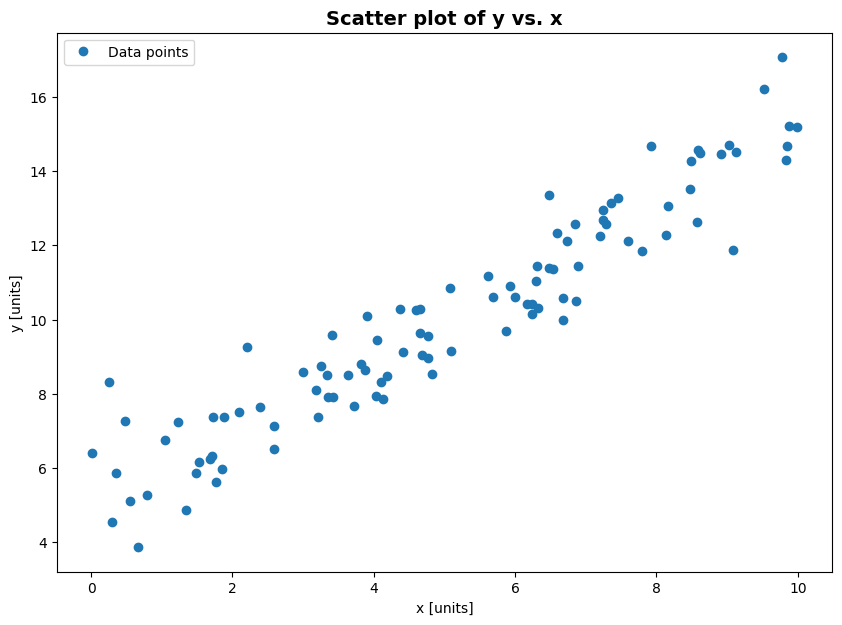

In [4]:
import matplotlib.pyplot as plt
A = 1.0
b = 5
N = 50

def lin_fn(N, A, b, x_span=[0, 10], var = 1.0):
    import numpy as np
    x = np.random.uniform(x_span[0], x_span[1], N)
    return x, x * A + b + np.random.normal(0, var, N)

x, y = lin_fn(100, A, b)
plt.figure(figsize=(10,7))
plt.plot(x, y, 'o', label='Data points')
plt.xlabel("x [units]")
plt.ylabel("y [units]")
plt.title("Scatter plot of y vs. x", fontsize=14, weight='bold')
plt.legend()
plt.show()



## Hvad er Lineær Regression?

**Lineær regression** finder den bedst passende rette linje gennem datapunkter for at modellere forholdet mellem to variable.

### Ligning:
$$y = Ax + b$$

Hvor:
- $y$ : denafhængige variabel (det vi forudsiger)
- $x$ : den uafhængige variabel (det vi bruger til at forudsige)
- $A$ : hældningen (ændringsraten)
- $b$ : skæringen med y-aksen (baselineværdi når x=0)


In [ ]:
help(linregress)

Slope: 1.0112, Intercept: 4.9319, R-squared: 0.8965, p-value: 4.5400e-50, Std Err: 0.0347


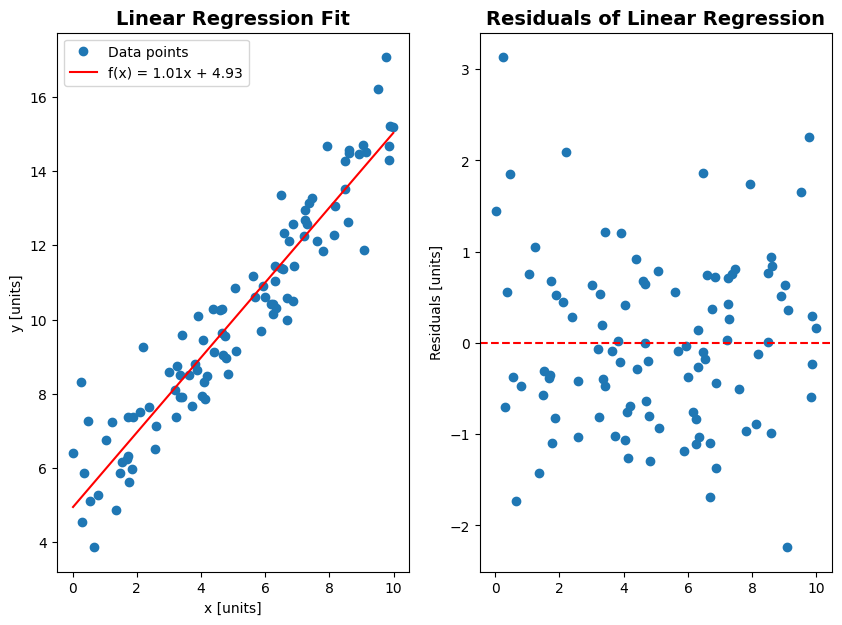

In [17]:
# Calculate linear regression
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(x, y)
print(f"Slope: {slope:.4f}, Intercept: {intercept:.4f}, R-squared: {r_value**2:.4f}, p-value: {p_value:.4e}, Std Err: {std_err:.4f}")   
x_fit = [min(x), max(x)]
y_fit = [slope * xi + intercept for xi in x_fit]
# visualize with scatterplot
fig, axs = plt.subplots(1, 2, figsize=(10,7))

axs[0].plot(x, y, 'o', label='Data points')
axs[0].plot(x_fit, y_fit, label=f'f(x) = {slope:.2f}x + {intercept:.2f}', color="red")
axs[0].set_xlabel("x [units]")
axs[0].set_ylabel("y [units]")
axs[0].set_title("Linear Regression Fit", fontsize=14, weight='bold')
axs[0].legend()

# plot residuals
y_pred = slope * x + intercept
residuals = y - y_pred
axs[1].scatter(x, residuals)
axs[1].axhline(0, color='red', linestyle='--')
axs[1].set_ylabel("Residuals [units]")
axs[1].set_title("Residuals of Linear Regression", fontsize=14, weight='bold')
plt.show()



### Evalueringsmetrikker:
- **R² (determinationskoefficient):** 
  - Range: 0 til 1
  - 0 = ingen lineær sammenhæng
  - 1 = perfekt lineær sammenhæng
- **Residualer:** forskelle mellem faktiske og forudsagte værdier (bør være tilfældige)

### Vigtig bemærkning:
**Korrelation ≠ Kausalitet**
- Bare fordi to variable er relaterede betyder det ikke at den ene forårsager den anden
- Overvej confounding-variable og alternative forklaringer

## Påvirker hjertefrekvensen (RR-interval) R-bølgens amplitude i EKG?
Lad os se på scatterplottet for `RR` og `R_amp` i filen `files/features_table_b001.csv`.  

In [ ]:
# Load file with NumPy and ignore missing values
RR_b, R_amp_b = np.genfromtxt('files/features_table_b001.csv', delimiter=',', skip_header=1, dtype=float, usecols=(0, 1), unpack=True)
# Header is RR,R_amp,RtoS2,S1toS2,Resp_amp,Resp_amp_RR_Rmean,Resp__amp_RR_std
mask = ~np.isnan(RR_b) & ~np.isnan(R_amp_b)
RR_b = RR_b[mask]
R_amp_b = R_amp_b[mask]

# Select features
RR_m, R_amp_m = np.genfromtxt('files/features_table_m001.csv', delimiter=',', skip_header=1, dtype=float, usecols=(0, 1), unpack=True)
# Header is RR,R_amp,RtoS2,S1toS2,Resp_amp,Resp_amp_RR_Rmean,Resp__amp_RR_std
mask = ~np.isnan(RR_m) & ~np.isnan(R_amp_m)
RR_m = RR_m[mask]
R_amp_m = R_amp_m[mask] 

labels = ["music", "baseline"]
RR_all = [RR_m, RR_b]
R_amp_all = [R_amp_m, R_amp_b]

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Create plots for baseline and music with their own colors
for label, rr, r_amp in zip(labels, RR_all, R_amp_all):
    assert isinstance(rr, np.ndarray) and isinstance(r_amp, np.ndarray) , "Inputs must be numpy arrays, was: {}, {}".format(type(rr), type(r_amp))
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(rr, r_amp)

    
    x = np.array([min(rr), max(rr)])
    y = intercept + slope * x

    # visualization
    # scatter with regression line
    ax1.scatter(rr, r_amp, alpha=0.3*1000/(1000+len(rr)), edgecolor='w')
    ax1.plot(x, y, linewidth=2, label=f'{label} fit: y={slope:.2f}x+{intercept:.2f}, r={r_value:.2f}')  # Add the regression line   
    # # residuals
    ax2.scatter(rr, r_amp - (slope * rr + intercept), alpha=0.3*1000/(1000+len(rr)))

# Finalize plots
ax1.set_xlabel("RR Intervals")
ax1.set_ylabel("R Amplitude (a.u.)")
ax1.set_title("RR Intervals vs R Amplitude with Linear Regression")
ax1.legend()
ax1.grid(True, alpha=0.3)
ax2.set_xlabel("RR Intervals")
ax2.set_ylabel("Residuals of R Amplitude")
ax2.set_title("Residuals of Linear Regression")
ax2.grid(True, alpha=0.3)


plt.show()

## Exercise: Finde R-peak og T-peak i et EKG

**Scenarie:**

Du arbejder som ingeniør i et Biotech startup, og har fået til opgave at analysere EKG-signaler fra patienter for at identificere vigtige hjertetræk.

**patientjournal**
- Navn: *Maja Nielsen*
- Alder: 42 år
- Dato/tid for optagelse: 2026-01-12 kl. 14:35
- Optagelsessted: Kardiologisk ambulatorium, Aarhus (Rum 3)
- Måleudstyr: 1-kanals EKG (Lead II), sampling $f_s$ angivet i filen/dine beregninger
- Formål: Screening af hjerterytme ved belastning (kort test)

For at gøre det nemmere at finde de karakteristiske peaks, skal du beregne en envelope af EKG-signalet.
Din opgave er at bruge envelopen til at finde både R-peaks (hjertets elektriske aktivering) og T-wave peaks (repolarisering).

Et EKG signal har energi mellem 1 og 150Hz

**Du ved:**
- Hvordan man beregner en envelope for et signal
- Hvordan man bruger peak-detektion på et signal
- Hvad R-peaks og T-waves repræsenterer i et EKG
- Hvordan man laver regler for- og klassificerer features

**Du skal:**
1. Indlæs et EKG-signal (fx fra `files/ECGPCG.csv` eller et andet relevant datasæt)
2. Beregn envelopen af EKG-signalet
3. Brug peak-detektion på envelopen til at finde R-peaks
4. Identificér også peaket for T-wave
5. Visualisér EKG, envelope, R-peaks og T-wave peaks i samme plot
6. Diskutér hvordan envelopen hjælper med at identificere disse features

**Etik-spørgsmål**
- Hvilke *metadata* er nødvendige for at andre kan reproducere din analyse (fx $f_s$, enhed, device/protokol) — og hvilke data bør du **ikke** gemme/dele?
- Hvis du gemmer/deler `files/peaks_ECGPCG.csv` eller figurer: er det (stadig) sundhedsdata/personoplysninger? Nævn 2 konkrete tiltag for **dataminimering** og **sikker lagring** (adgang, kryptering, sletning).




## Exercise: Hurtig puls- og outlier-analyse fra R-peaks

**Scenarie:**

Du skal lave en hurtig QA af en kort EKG-optagelse og rapportere puls og afvigelser.

**patientjournal**
- Navn: *Jonas Holm*
- Alder: 35 år
- Dato/tid for optagelse: 2026-01-12 kl. 15:05
- Optagelsessted: Kardiologisk ambulatorium, Aarhus (Rum 2)
- Måleudstyr: 1-kanals EKG (Lead II)
- Formål: Kontrolmåling efter træningssession

**Du ved:**
- Hvordan man beregner RR-intervaller fra R-peaks
- Hvordan man beregner puls $\mathrm{HR}=60/\mathrm{RR}$
- Hvordan man finder outliers med $\pm 2\,\mathrm{SD}$

**Du skal:**
1. Brug R-peaks fra Exercise 1 (eller find dem igen)
2. Beregn RR-intervaller og puls i bpm
3. Plot puls over tid (beat-nummer på x-aksen)
4. Markér beats hvor puls afviger mere end $2\,\mathrm{SD}$ fra middelværdien
5. Giv en kort forklaring på mulige årsager til outliers (artefakter, ectopiske slag, bevægelse)

**Etik-spørgsmål**
- Hvilke *minimumsoplysninger* (fx antal beats, gennemsnit, spredning) kan deles uden at dele rå signaler?
- Nævn 2 konkrete tiltag for dataminimering og sikker lagring i denne type korttidsmåling.